## Обучение модели (выбор модели)

In [2]:
import pandas as pd
import numpy as np
from fairml import audit_model
from fairml import plot_dependencies
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
# Обучающие данные
df_train = pd.read_csv("./input/Webpages_Classification_train_data.csv/Webpages_Classification_train_data.csv")
df_train.drop(columns = "Unnamed: 0", inplace = True)

In [5]:
# Тренировачные данные
df_test = pd.read_csv("./input/Webpages_Classification_test_data.csv/Webpages_Classification_test_data.csv")
df_test.drop(columns = "Unnamed: 0", inplace = True)

In [6]:
# Кодировка стран
count = pd.read_csv('./input/tableconvert_csv_pkcsig.csv')

In [7]:
countries = dict(zip(count['Country'], count['Alpha-3 code']))

df_train['iso_3'] = df_train['geo_loc']
df_train['iso_3'].replace(countries, inplace = True)

df_train.https.replace({'yes' : 'HTTPS', 'no' : 'HTTP'}, inplace = True)

# Создание новых признаков
# Подсчет специальных символов в содержимом
def count_special(string):
    count = 0
    for char in string:
        if not(char.islower()) and not(char.isupper()) and not(char.isdigit()):
            if char != ' ':
                count += 1
    return count

# Определение типа сети [A, B, C]
def network_type(ip):
    ip_str = ip.split(".")
    ip = [int(x) for x in ip_str]

    if ip[0]>=0 and ip[0]<=127:
        return (ip_str[0], "A")
    elif ip[0]>=128 and ip[0]<=191:
        return (".".join(ip_str[0:2]), "B")
    else:
        return (".".join(ip_str[0:3]), "C")
    
# Добавление признака с типом сети
df_train['Network']= df_train['ip_add'].apply(lambda x : network_type(x))
df_train['net_part'], df_train['net_type'] = zip(*df_train.Network)
df_train.drop(columns = ['Network'], inplace = True)

# Признак с количеством специальных знаков
df_train['special_char'] = df_train['content'].apply(lambda x: count_special(x))

# Длина признака Content
df_train['content_len'] = df_train['content'].apply(lambda x: len(x))

df_train.label.replace({'bad' : 'Malicious', 'good' : 'Benign'}, inplace = True)

df_train.label.replace({'Malicious' : 1, 'Benign' : 0}, inplace = True)

ls = ['geo_loc', 'tld', 'who_is', 'https', 'net_type']
le_dict = {}

for feature in ls:
    le = LabelEncoder()
    le_dict[feature] = le
    df_train[feature] = le.fit_transform(df_train[feature])
    
# Конечные атрибуты, которые пойду в обучающую выборку
df_train = df_train[['url_len', 'geo_loc', 'tld', 'who_is', 'https', 'js_len', 'js_obf_len', 'label', 'net_type', 'special_char', 'content_len']]

ss_dict = {}

for feature in ['content_len', 'special_char']:
    ss = StandardScaler()
    ss_fit = ss.fit(df_train[feature].values.reshape(-1, 1))
    ss_dict[feature] = ss_fit
    d = ss_fit.transform(df_train[feature].values.reshape(-1, 1))
    df_train[feature] = pd.DataFrame(d, index = df_train.index, columns = [feature])

In [8]:
df_test.https.replace({'yes' : 'HTTPS', 'no' : 'HTTP'}, inplace = True)
df_test.label.replace({'bad' : 'Malicious', 'good' : 'Benign'}, inplace = True)

df_test['Network']= df_test['ip_add'].apply(lambda x : network_type(x))
df_test['net_part'], df_test['net_type'] = zip(*df_test.Network)
df_test.drop(columns = ['Network'], inplace = True)

df_test['special_char'] = df_test['content'].apply(lambda x: count_special(x))

df_test['content_len'] = df_test['content'].apply(lambda x: len(x))

for feature in ls:
    le = le_dict[feature]
    df_test[feature] = le.fit_transform(df_test[feature])

df_test.label.replace({'Malicious' : 1, 'Benign' : 0}, inplace = True)

ss_fit = ss_dict['content_len']
d = ss_fit.transform(df_test['content_len'].values.reshape(-1, 1))
df_test['content_len'] = pd.DataFrame(d, index = df_test.index, columns = ['content_len'])

ss_fit = ss_dict['special_char']
d = ss_fit.transform(df_test['special_char'].values.reshape(-1, 1))
df_test['special_char'] = pd.DataFrame(d, index = df_test.index, columns = ['special_char'])

df_test = df_test[['url_len', 'geo_loc', 'tld', 'who_is', 'https', 'js_len', 'js_obf_len', 'label', 'net_type', 'special_char', 'content_len']]

##### Метрика Accuracy

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

%matplotlib notebook

In [1]:
train= df_train.iloc[:500000,]
test= df_test.iloc[:,]

print(len(train), 'train examples')
print(len(test), 'test examples')

NameError: name 'df_train' is not defined

In [10]:
y_train = train['label'] 
X_train = train.drop(columns=['label'])

y_test = test['label'] 
X_test = test.drop(columns=['label'])

               Classifier  Accuracy
0    KNeighborsClassifier  0.099894
0                     SVC  0.099896
0  DecisionTreeClassifier  0.099924
0  RandomForestClassifier  0.099968
0              GaussianNB   0.09989
0      LogisticRegression  0.099791


<IPython.core.display.Javascript object>


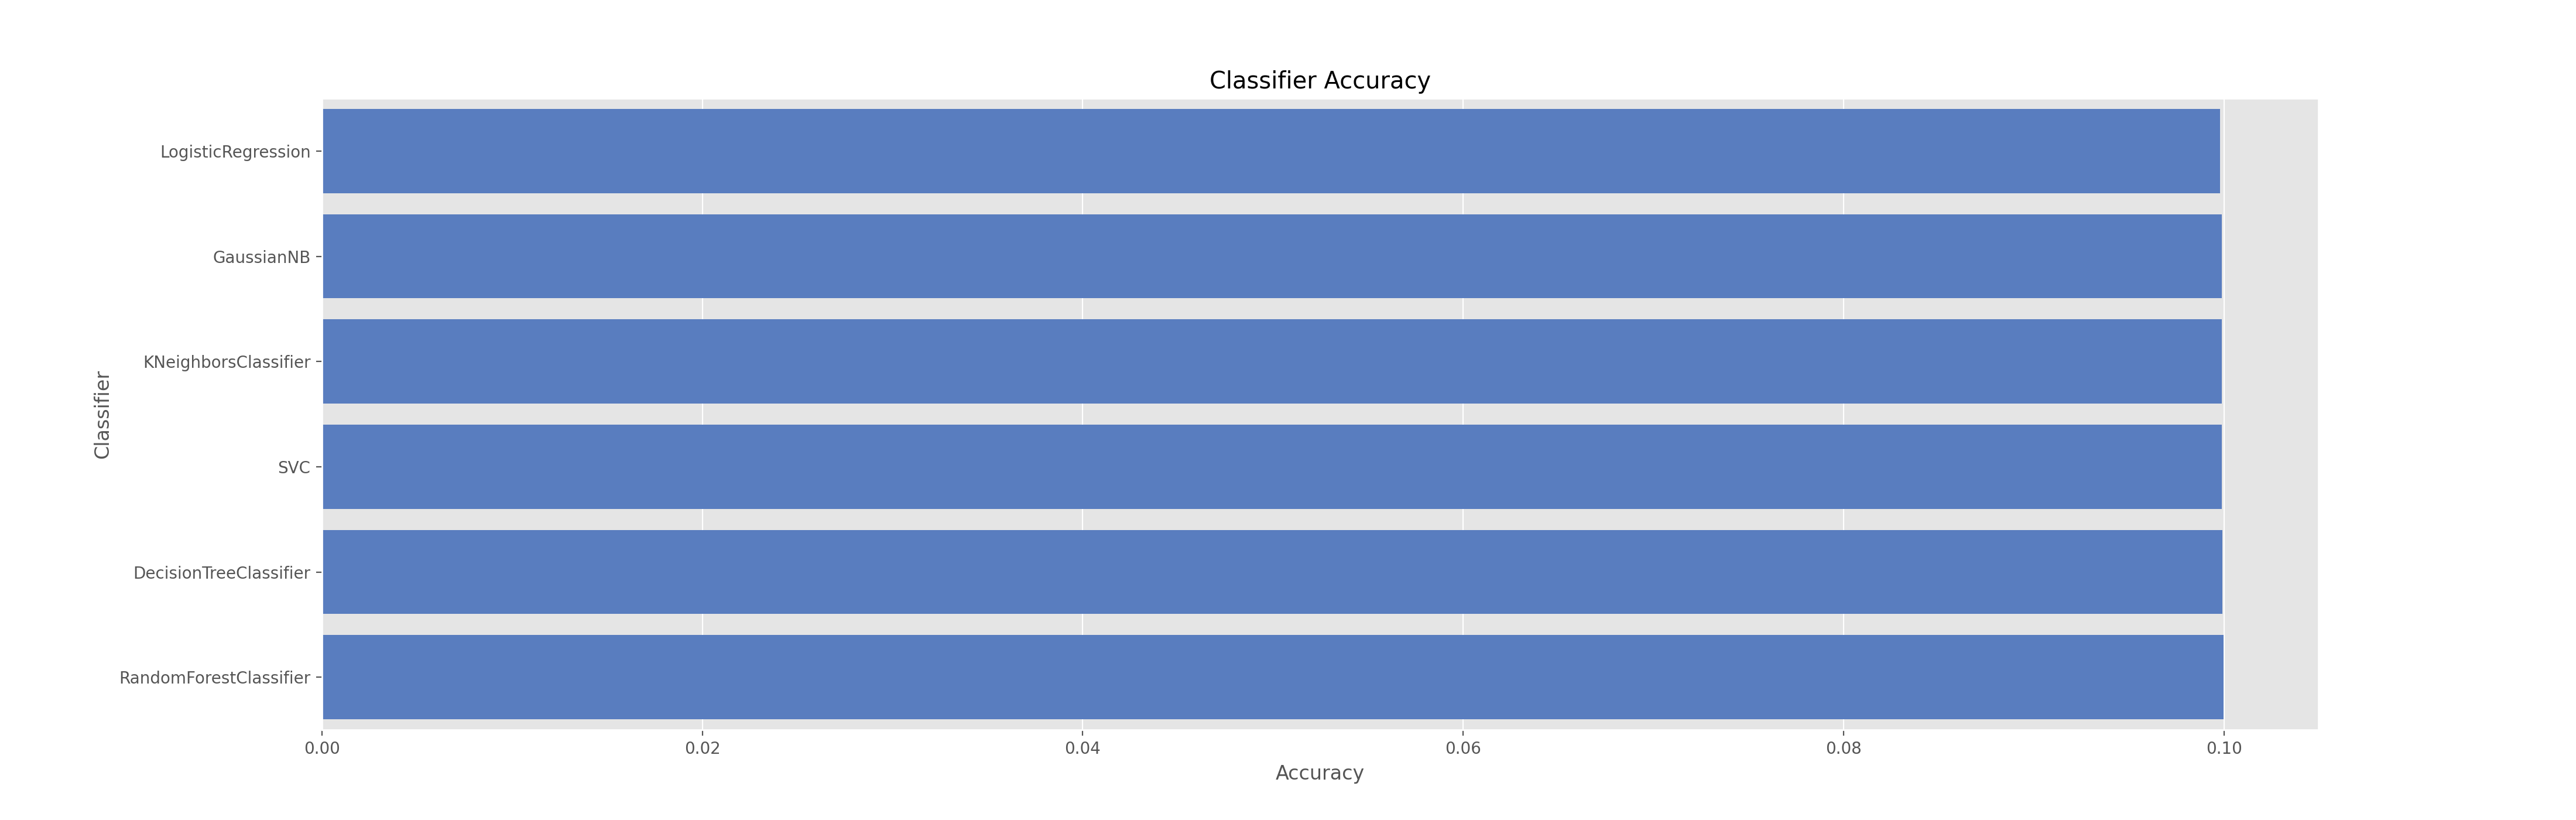

In [74]:
classifiers = [
    KNeighborsClassifier(5),
    SVC(probability=True, kernel='rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    LogisticRegression(solver='lbfgs', max_iter=1000),
]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = pd.concat([log, log_entry])

print(log)
    
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

plt.rcParams['figure.figsize'] = [22, 7]
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log.sort_values(by='Accuracy'), color="b")
plt.show()

               Classifier        f1
0    KNeighborsClassifier  0.096333
0                     SVC   0.09603
0  DecisionTreeClassifier  0.099282
0  RandomForestClassifier  0.099162
0              GaussianNB   0.09603
0      LogisticRegression  0.098321


<IPython.core.display.Javascript object>


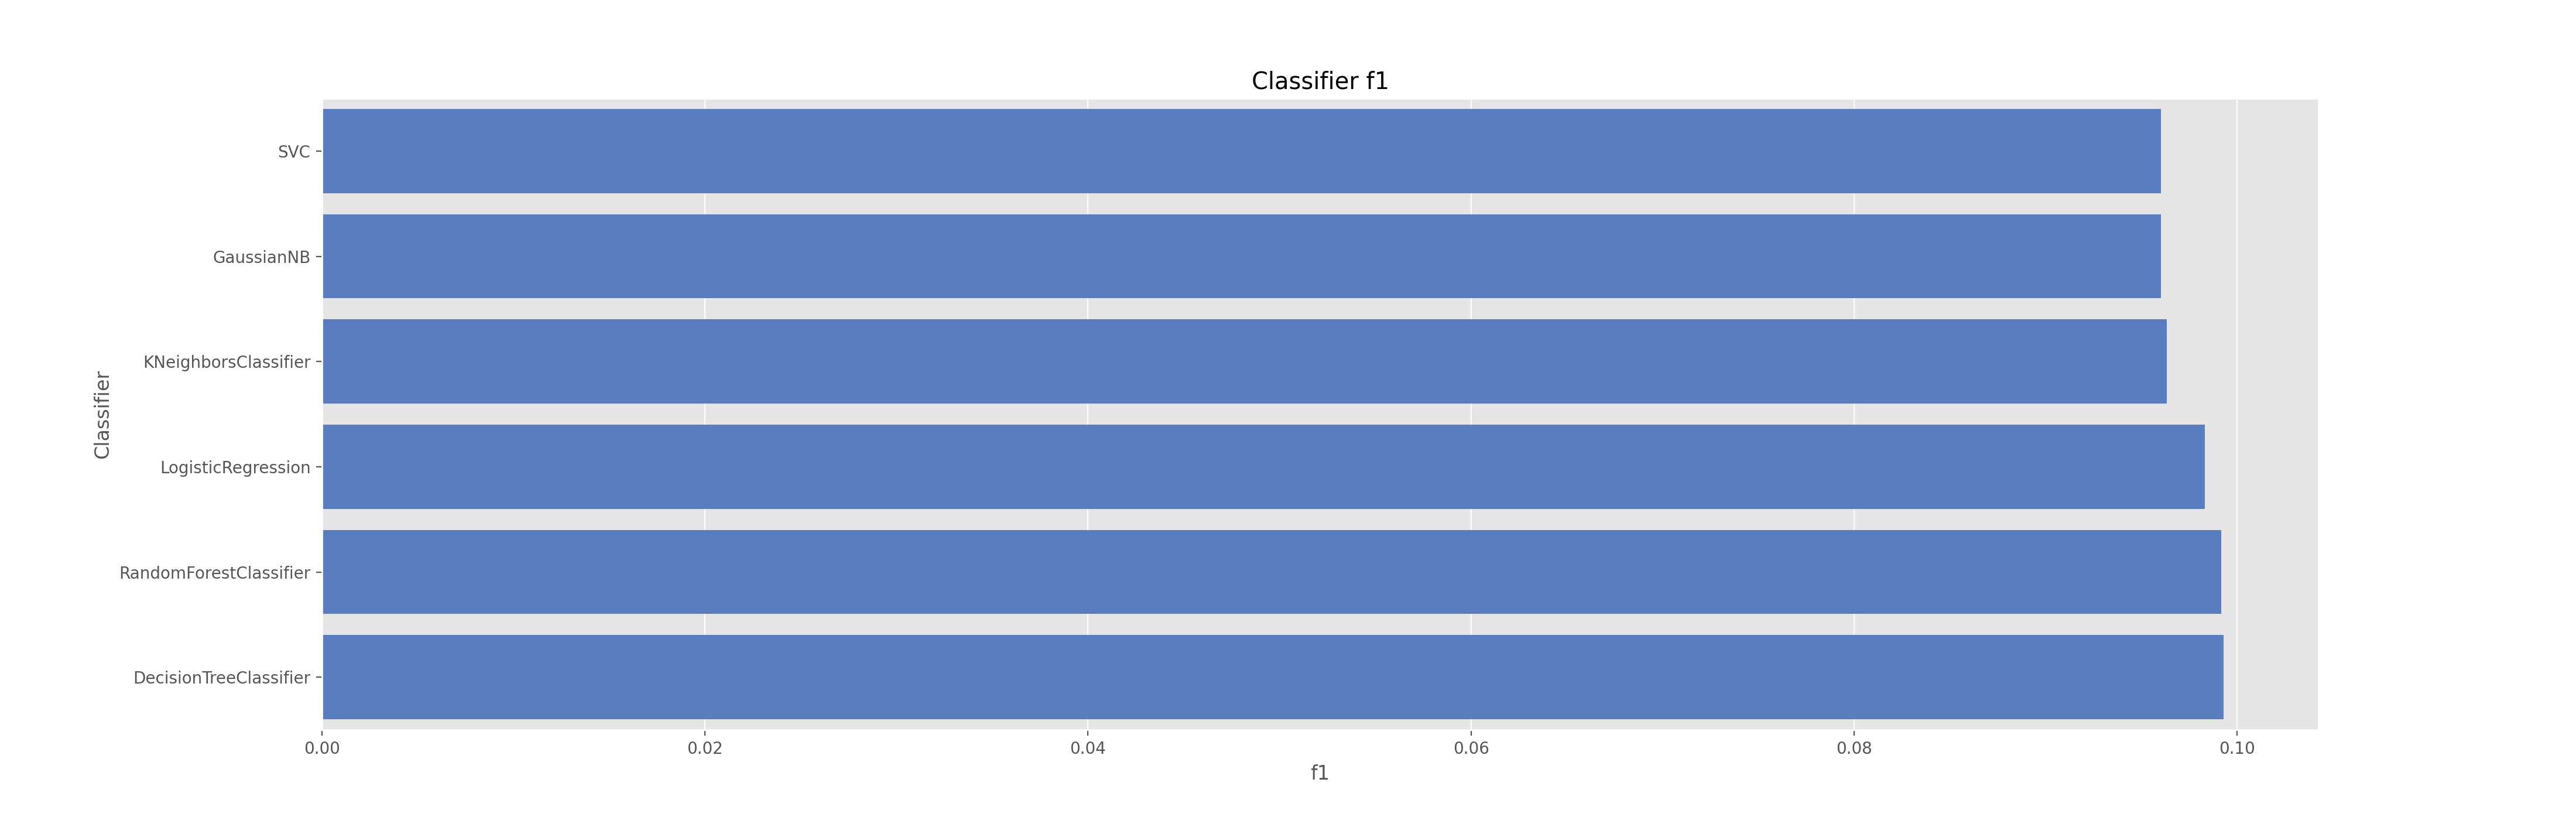

In [43]:
classifiers = [
    KNeighborsClassifier(5),
    SVC(probability=True, kernel='rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    LogisticRegression(solver='lbfgs', max_iter=1000),
]

log_cols = ["Classifier", "f1"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = f1_score(y_test, train_predictions)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = pd.concat([log, log_entry])

print(log)

plt.xlabel('f1')
plt.title('Classifier f1')

plt.rcParams['figure.figsize'] = [22, 7]
sns.set_color_codes("muted")
sns.barplot(x='f1', y='Classifier', data=log.sort_values(by='f1'), color="b")
plt.show()

## FairML

In [88]:
# temporary work around down to virtualenv
# matplotlib issue.
matplotlib.use('Agg')

# import specific projection format.
from fairml import audit_model
from fairml import plot_dependencies

plt.style.use('ggplot')
plt.figure(figsize=(6, 6))


#  quick setup of Logistic regression
#  perhaps use a more crazy classifier
#clf_1 = RandomForestClassifier()
#clf_1.fit(X_train.values, y_train.values)

#  call audit model
importancies, _ = audit_model(clf_1.predict, X_test)

# print feature importance
print(importancies)

# generate feature dependence plot
fig = plot_dependencies(
    importancies.median(),
    reverse_values=False,
    title="FairML feature dependence logistic regression model"
)

file_name = "fairml_propublica_linear_direct.png"
plt.savefig(file_name, transparent=False, bbox_inches='tight', dpi=250)

Feature: url_len,	 Importance: -0.002312576326070499
Feature: geo_loc,	 Importance: 0.0022048218736012643
Feature: tld,	 Importance: -0.0008150657302160063
Feature: who_is,	 Importance: 0.0042438676664806295
Feature: https,	 Importance: -0.00046141009134262047
Feature: js_len,	 Importance: 0.021258019417904922
Feature: js_obf_len,	 Importance: 0.018873606790188267
Feature: net_type,	 Importance: 0.001041626373869269
Feature: special_char,	 Importance: -0.02215044731912448
Feature: content_len,	 Importance: 0.018550343432780562


In [13]:
clf_1 = RandomForestClassifier()
clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_test)

#model_result_labels = stat_utils.binary_result_labels(y_test, y_pred)
#display(model_result_labels.rename_axis('count').reset_index().groupby('prediction result').count())

NameError: name 'stat_utils' is not defined

In [20]:
from fairmlhealth import measure, report, stat_utils
report.compare(X_test, y_test, X_test['https'], clf_1)

this method is deprecated in favour of `Styler.format(precision=..)`


In [62]:
y_pred = clf.predict(X_test)
print("FairMLHealth Stratified Performance Table")
measure.performance(X_test['https'], 
                    y_test, 
                    y_pred, 
                    y_prob=clf.predict_proba(X_test)[:,1])

FairMLHealth Stratified Performance Table


C:\Users\Public\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Public\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,Feature Name,Feature Value,Obs.,Mean Target,Mean Prediction,Accuracy,F1-Score,FPR,PR AUC,Precision,ROC AUC,TPR
0,ALL FEATURES,ALL VALUES,1200.0,0.4867,0.4867,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,https,0,644.0,0.8028,0.8028,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2,https,1,556.0,0.1205,0.1205,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [23]:
# Metrics function
from collections import OrderedDict
from aif360.metrics.classification_metric import ClassificationMetric
from aif360.datasets import StandardDataset

from aif360.sklearn.metrics import consistency_score, generalized_entropy_error, between_group_generalized_entropy_error
import sklearn.metrics

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+classified_metric_pred.true_negative_rate())
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    
    
    
    metrics["Consistency Scores"] = consistency_score(X_test,y_pred)
    metrics["Generalized Entropy"] = classified_metric_pred.generalized_entropy_index()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    metrics["Coefficient of Variation"] = classified_metric_pred.coefficient_of_variation()
    metrics["Generalized Entropy Error"] = generalized_entropy_error(y_test, y_pred)
    #metrics["Between Group Generalized Entropy Error"] = between_group_generalized_entropy_error(y_test, y_pred, prot_attr='https')
    
    metrics["Accuracy"] = accuracy_score(y_test, y_pred)
    metrics["F1-score"] = f1_score(y_test, y_pred)
    #metrics["Precision"] = precision_score(y_test, y_pred)
    #metrics["Recall"] = recall_score(y_test, y_pred)
    
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    print (metrics)
    return metrics

#def audit_compare()

priv_groups = [{'https': 1}]
unpriv_groups = [{'https': 0}]
dataset = pd.concat([X_test, y_test], axis=1)
dataset = StandardDataset(dataset, label_name='label', favorable_classes=[0], protected_attribute_names=['https'], privileged_classes=[[1]])
classified_dataset = dataset.copy()
classified_dataset.labels = y_pred

compute_metrics(dataset, classified_dataset, unprivileged_groups=unpriv_groups, privileged_groups=priv_groups)


Balanced accuracy = 0.9952
Equal opportunity difference = -0.0005
Statistical parity difference = -0.0897
Average odds difference = -0.0201
Disparate impact = 0.9100
Consistency Scores = 0.9992
Generalized Entropy = 0.0002
Theil index = 0.0002
Coefficient of Variation = 0.0254
Generalized Entropy Error = 0.0002
Accuracy = 0.9997
F1-score = 0.9927
OrderedDict([('Balanced accuracy', 0.9951679924362471), ('Equal opportunity difference', -0.0005081125570859379), ('Statistical parity difference', -0.0897211007030313), ('Average odds difference', -0.020074594197437116), ('Disparate impact', 0.910036956468162), ('Consistency Scores', 0.9992147739643139), ('Generalized Entropy', 0.00016159341274224828), ('Theil index', 0.00019267503375102404), ('Coefficient of Variation', 0.025423879542056382), ('Generalized Entropy Error', 0.00016165950411552255), ('Accuracy', 0.9996767366425923), ('F1-score', 0.9927270466836576)])


OrderedDict([('Balanced accuracy', 0.9951679924362471),
             ('Equal opportunity difference', -0.0005081125570859379),
             ('Statistical parity difference', -0.0897211007030313),
             ('Average odds difference', -0.020074594197437116),
             ('Disparate impact', 0.910036956468162),
             ('Consistency Scores', 0.9992147739643139),
             ('Generalized Entropy', 0.00016159341274224828),
             ('Theil index', 0.00019267503375102404),
             ('Coefficient of Variation', 0.025423879542056382),
             ('Generalized Entropy Error', 0.00016165950411552255),
             ('Accuracy', 0.9996767366425923),
             ('F1-score', 0.9927270466836576)])